# AutoML Image Classification: Added Noise (Digits)

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

![](imgs/gaussian_noise.png)

In [2]:
import random as rn
from abc import ABC, abstractmethod

import autokeras as ak
import h2o
import matplotlib.pyplot as plt
import numpy as np
from h2o.automl import H2OAutoML
from keras.datasets import fashion_mnist
from numpy.random import RandomState
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier

from dpemu import runner
from dpemu.filters.common import GaussianNoise, Clip
from dpemu.filters.image import RotationPIL
from dpemu.nodes import Array
from dpemu.nodes.series import Series
from dpemu.plotting_utils import visualize_scores, print_results_by_model
from dpemu.utils import generate_tmpdir

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


Using TensorFlow backend.


In [3]:
def get_data():
    random_state = RandomState(42)
    x, y = load_digits(return_X_y=True)
    y = y.astype(np.uint8)
    return train_test_split(x, y, test_size=1/7, random_state=random_state)
    # (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    # s = x_train.shape[1]
    # x_train = x_train.reshape((len(x_train), s**2)).astype(np.float64)
    # x_test = x_test.reshape((len(x_test), s**2)).astype(np.float64)    
    # return x_train, x_test, y_train, y_test

In [4]:
def get_err_root_node():
    err_img_node = Array(reshape=(8, 8))
    # err_img_node = Array(reshape=(28, 28))

    # err_root_node = Series(err_img_node)
    # err_img_node.addfilter(RotationPIL("max_angle"))
    # return err_root_node
    err_root_node = Series(err_img_node)
    err_img_node.addfilter(GaussianNoise("mean", "std"))
    err_img_node.addfilter(Clip("min_val", "max_val"))
    return err_root_node

In [5]:
def get_err_params_list(data):
    # angle_steps = np.linspace(0, 90, num=6)
    # err_params_list = [{"max_angle": a} for a in angle_steps]
    # return err_params_list
    min_val = np.amin(data)
    max_val = np.amax(data)
    std_steps = np.round(np.linspace(0, max_val, num=6), 3)
    err_params_list = [{"mean": 0, "std": std, "min_val": min_val, "max_val": max_val} for std in std_steps]
    return err_params_list

In [6]:
class Preprocessor:

    def run(self, train_data, test_data, params):
        return np.round(train_data).astype(np.uint8), np.round(test_data).astype(np.uint8), {}

In [7]:
class AbstractModel(ABC):

    def __init__(self):
        self.time_limit_mins = 60*2
        self.seed = 42
        self.random_state = RandomState(self.seed)
        np.random.seed(self.seed)

    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    @abstractmethod
    def get_accuracy(self, data, labels, fitted_model, params):
        pass

    @abstractmethod
    def get_best_pipeline(self, fitted_model):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        fitted_model = self.get_fitted_model(train_data, train_labels, params)

        results = {
            "test_acc": self.get_accuracy(test_data, test_labels, fitted_model, params),
            "train_acc": self.get_accuracy(train_data, train_labels, fitted_model, params),
            "best_pipeline": self.get_best_pipeline(fitted_model),
        }
        print(type(fitted_model))
        print(results["test_acc"])
        return results

class TPOTClassifierModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return TPOTClassifier(
            max_time_mins=self.time_limit_mins,
            max_eval_time_mins=self.time_limit_mins,
            n_jobs=-1,
            random_state=self.seed,
            verbosity=1,
        ).fit(train_data, train_labels)

    def get_accuracy(self, data, labels, fitted_model, params):
        return round(fitted_model.score(data, labels), 3)

    def get_best_pipeline(self, fitted_model):
        return [step[1] for step in fitted_model.fitted_pipeline_.steps]

class H2OAutoMLModel(AbstractModel):

    def __init__(self):
        super().__init__()
        h2o.init(name=f"#{rn.SystemRandom().randint(1, 2**30)}", nthreads=20)
        h2o.no_progress()

    def get_fitted_model(self, train_data, train_labels, params):
        train_data = h2o.H2OFrame(np.concatenate((train_data, train_labels.reshape(-1, 1)), axis=1))
        x = np.array(train_data.columns)[:-1].tolist()
        y = np.array(train_data.columns)[-1].tolist()
        train_data[y] = train_data[y].asfactor()
        aml = H2OAutoML(max_runtime_secs=60*self.time_limit_mins, seed=self.seed)
        aml.train(x=x, y=y, training_frame=train_data)
        return aml

    def get_accuracy(self, data, labels, fitted_model, params):
        data = h2o.H2OFrame(np.concatenate((data, labels.reshape(-1, 1)), axis=1))
        y = np.array(data.columns)[-1].tolist()
        data[y] = data[y].asfactor()
        pred = fitted_model.predict(data).as_data_frame(header=False)["predict"].values.astype(int)
        return np.round(np.mean(pred == labels), 3)

    def get_best_pipeline(self, fitted_model):
        leader_params = fitted_model.leader.get_params()
        best_pipeline = [leader_params["model_id"]["actual_value"]["name"]]
        if "base_models" in leader_params:
            for base_model in leader_params["base_models"]["actual_value"]:
                best_pipeline.append(base_model["name"])
        h2o.cluster().shutdown()
        return best_pipeline

class AutoKerasModel(AbstractModel):

    def __init__(self):
        super().__init__()
        import tensorflow as tf
        tf.set_random_seed(self.seed)
        import torch
        torch.multiprocessing.set_sharing_strategy("file_system")
        torch.manual_seed(self.seed)

    def get_fitted_model(self, x_train, y_train, params):
        s = np.sqrt(x_train.shape[1]).astype(int)
        x_train = x_train.reshape((len(x_train), s, s, 1))
        clf = ak.ImageClassifier(augment=False, path=generate_tmpdir(), verbose=False)
        clf.fit(x_train, y_train, time_limit=60*self.time_limit_mins)
        return clf

    def get_accuracy(self, x, y, clf, params):
        s = np.sqrt(x.shape[1]).astype(int)
        x = x.reshape((len(x), s, s, 1))
        y_pred = clf.predict(x)
        return np.round(accuracy_score(y_true=y, y_pred=y_pred), 3)

    def get_best_pipeline(self, clf):
        return [m for i, m in enumerate(clf.cnn.best_model.produce_model().modules()) if i > 0]

In [8]:
def get_model_params_dict_list(train_labels, test_labels):
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    return [
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
    ]

In [9]:
def visualize(df):
    visualize_scores(
        df,
        score_names=["test_acc", "train_acc"],
        is_higher_score_better=[True, True],
        # err_param_name="max_angle",
        err_param_name="std",
        title="Classification scores with added error"
    )
    plt.show()

In [10]:
train_data, test_data, train_labels, test_labels = get_data()

df = runner.run(
    train_data=train_data,
    test_data=test_data,
    preproc=Preprocessor,
    preproc_params=None,
    err_root_node=get_err_root_node(),
    # err_params_list=get_err_params_list(),
    err_params_list=get_err_params_list(train_data),
    model_params_dict_list=get_model_params_dict_list(train_labels, test_labels),
    n_processes=1
)

  0%|          | 0/6 [00:00<?, ?it/s]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.988

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.984

121.03 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(LinearSVC(DecisionTreeClassifier(PCA(input_matrix, iterated_power=6, svd_solver=randomized), criterion=gini, max_depth=6, min_samples_leaf=10, min_samples_split=2), C=25.0, dual=True, loss=squared_hinge, penalty=l2, tol=0.01), learning_rate=0.001, max_depth=8, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=13, n_estimators=100, subsample=1.0), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.984

120.28 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(LinearSVC(DecisionTreeClassifier(PCA(input_matrix, iterated_power=6, svd_solver=randomized), criterion=gini, max_depth=6, min_samples_leaf=10, min_samples_split=2), C=25.0, dual=True, loss=squared_hinge, penalty=l2, tol=0.01), learning_rate=0.001, max_depth=8, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=13, n_estimators=100, subsample=1.0), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.984

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpau_de_jc

  JVM stdout: /wrk/users/thalvari/tmpau_de_jc/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpau_de_jc/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,18 days
H2O cluster name:,#855545903
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_9874 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.981

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmphiqeczpm

  JVM stdout: /wrk/users/thalvari/tmphiqeczpm/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmphiqeczpm/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,18 days
H2O cluster name:,#39402272
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8d6d closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.977

 17%|█▋        | 1/6 [11:35:20<57:56:42, 41720.50s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.895

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.938

120.89 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(SelectPercentile(LinearSVC(SGDClassifier(input_matrix, alpha=0.001, eta0=1.0, fit_intercept=False, l1_ratio=0.25, learning_rate=invscaling, loss=modified_huber, penalty=elasticnet, power_t=0.0), C=0.0001, dual=True, loss=squared_hinge, penalty=l2, tol=0.001), percentile=79), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.957

123.68 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(LinearSVC(DecisionTreeClassifier(PCA(input_matrix, iterated_power=6, svd_solver=randomized), criterion=gini, max_depth=6, min_samples_leaf=10, min_samples_split=2), C=25.0, dual=True, loss=squared_hinge, penalty=l2, tol=0.01), learning_rate=0.001, max_depth=8, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=13, n_estimators=100, subsample=1.0), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.965

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp2pjl1gfp

  JVM stdout: /wrk/users/thalvari/tmp2pjl1gfp/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp2pjl1gfp/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,19 days
H2O cluster name:,#213677293
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b5ee closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.942

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmperdcdu_x

  JVM stdout: /wrk/users/thalvari/tmperdcdu_x/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmperdcdu_x/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,19 days
H2O cluster name:,#806655811
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_9934 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.751

 33%|███▎      | 2/6 [23:25:33<46:39:12, 41988.13s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.759

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.669

120.92 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(SelectFwe(LinearSVC(SelectFwe(GradientBoostingClassifier(input_matrix, learning_rate=0.5, max_depth=9, max_features=0.8500000000000001, min_samples_leaf=13, min_samples_split=4, n_estimators=100, subsample=0.4), alpha=0.038), C=5.0, dual=False, loss=squared_hinge, penalty=l2, tol=0.1), alpha=0.019), n_neighbors=20, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.817

122.18 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(LinearSVC(DecisionTreeClassifier(PCA(input_matrix, iterated_power=6, svd_solver=randomized), criterion=gini, max_depth=6, min_samples_leaf=10, min_samples_split=2), C=25.0, dual=True, loss=squared_hinge, penalty=l2, tol=0.01), learning_rate=0.001, max_depth=8, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=13, n_estimators=100, subsample=1.0), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.895

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp46mte2_v

  JVM stdout: /wrk/users/thalvari/tmp46mte2_v/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp46mte2_v/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,19 days
H2O cluster name:,#169381245
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_804b closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.813

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp5oqrvxn5

  JVM stdout: /wrk/users/thalvari/tmp5oqrvxn5/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp5oqrvxn5/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,19 days
H2O cluster name:,#129986603
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_a9d3 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.51

 50%|█████     | 3/6 [34:48:49<34:44:31, 41690.61s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.502

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.463

122.10 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(CombineDFs(input_matrix, SelectFwe(CombineDFs(CombineDFs(input_matrix, input_matrix), Nystroem(input_matrix, gamma=0.30000000000000004, kernel=additive_chi2, n_components=4)), alpha=0.016)), n_neighbors=84, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.665

121.82 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(LinearSVC(DecisionTreeClassifier(PCA(input_matrix, iterated_power=6, svd_solver=randomized), criterion=gini, max_depth=6, min_samples_leaf=10, min_samples_split=2), C=25.0, dual=True, loss=squared_hinge, penalty=l2, tol=0.01), learning_rate=0.001, max_depth=8, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=13, n_estimators=100, subsample=1.0), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.696

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpfouksmli

  JVM stdout: /wrk/users/thalvari/tmpfouksmli/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpfouksmli/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,20 days
H2O cluster name:,#1005967064
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_a64a closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.658

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp7v2nxbwn

  JVM stdout: /wrk/users/thalvari/tmp7v2nxbwn/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp7v2nxbwn/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,20 days
H2O cluster name:,#806263268
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b758 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.389

 67%|██████▋   | 4/6 [46:06:26<22:59:21, 41380.53s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.331

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.354

125.52 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

MultinomialNB(SelectPercentile(MaxAbsScaler(XGBClassifier(CombineDFs(CombineDFs(CombineDFs(CombineDFs(input_matrix, input_matrix), input_matrix), input_matrix), input_matrix), learning_rate=0.5, max_depth=10, min_child_weight=14, n_estimators=100, nthread=1, subsample=0.1)), percentile=76), alpha=100.0, fit_prior=False)

<class 'tpot.tpot.TPOTClassifier'>

0.49

121.29 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(LinearSVC(DecisionTreeClassifier(PCA(input_matrix, iterated_power=6, svd_solver=randomized), criterion=gini, max_depth=6, min_samples_leaf=10, min_samples_split=2), C=25.0, dual=True, loss=squared_hinge, penalty=l2, tol=0.01), learning_rate=0.001, max_depth=8, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=13, n_estimators=100, subsample=1.0), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.521

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp9td0utaj

  JVM stdout: /wrk/users/thalvari/tmp9td0utaj/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp9td0utaj/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,20 days
H2O cluster name:,#794940758
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8a6f closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.471

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpd42g0asp

  JVM stdout: /wrk/users/thalvari/tmpd42g0asp/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpd42g0asp/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,20 days
H2O cluster name:,#967891501
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_917a closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.315

 83%|████████▎ | 5/6 [57:26:11<11:26:41, 41201.91s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.226

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.257

126.96 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

MultinomialNB(MultinomialNB(RFE(input_matrix, criterion=gini, max_features=0.7500000000000001, n_estimators=100, step=0.2), alpha=0.001, fit_prior=True), alpha=100.0, fit_prior=True)

<class 'tpot.tpot.TPOTClassifier'>

0.354

121.71 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(LinearSVC(DecisionTreeClassifier(PCA(input_matrix, iterated_power=6, svd_solver=randomized), criterion=gini, max_depth=6, min_samples_leaf=10, min_samples_split=2), C=25.0, dual=True, loss=squared_hinge, penalty=l2, tol=0.01), learning_rate=0.001, max_depth=8, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=13, n_estimators=100, subsample=1.0), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.37

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpq8bxfixe

  JVM stdout: /wrk/users/thalvari/tmpq8bxfixe/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpq8bxfixe/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,20 days
H2O cluster name:,#688467871
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8998 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.335

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp97y605t1

  JVM stdout: /wrk/users/thalvari/tmp97y605t1/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp97y605t1/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,21 days and 37 minutes
H2O cluster name:,#635508116
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b886 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.16

100%|██████████| 6/6 [68:50:42<00:00, 41162.56s/it]   

100%|██████████| 6/6 [68:50:42<00:00, 41307.06s/it]

'AutoKeras #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.988,0.999,0.151,0.002,7205.46
3.2,0.895,0.994,0.101,0.001,7200.54
6.4,0.759,0.981,0.14,0.001,7208.48
9.6,0.502,0.953,0.104,0.001,7215.78
12.8,0.331,0.821,0.105,0.001,7222.58
16,0.226,0.826,0.102,0.001,7232.75


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80,pipe_81,pipe_82
0,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),GlobalAvgPool2d(),"Linear(in_features=512, out_features=10, bias=True)","C

'AutoKerasClean #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.984,0.998,0.151,0.002,7219.76
3.2,0.938,0.999,0.101,0.001,7207.28
6.4,0.669,0.999,0.14,0.001,7259.65
9.6,0.463,0.999,0.104,0.001,7209.63
12.8,0.354,0.999,0.105,0.001,7247.1
16,0.257,0.999,0.102,0.001,7215.02


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80
0,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),GlobalAvgPool2d(),"Linear(in_features=512, out_features=10, bias=True)",ReLU(),nan,nan,nan

'H2OAutoML #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.981,1,0.151,0.002,6388.11
3.2,0.942,1,0.101,0.001,7112.21
6.4,0.813,1,0.14,0.001,5518.27
9.6,0.658,0.994,0.104,0.001,5190.52
12.8,0.471,0.896,0.105,0.001,5091.68
16,0.335,1,0.102,0.001,5262.44


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80,pipe_81,pipe_82,pipe_83,pipe_84,pipe_85,pipe_86,pipe_87,pipe_88,pipe_89,pipe_90,pipe_91,pipe_92,pipe_93,pipe_94,pipe_95,pipe_96,pipe_97,pipe_98,pipe_99,pipe_100,pipe_101,pipe_102,pipe_103,pipe_104,pipe_105,pipe_106,pipe_107,pipe_108,pipe_109,pipe_110,pipe_111,pipe_112,pipe_113,pipe_114,pipe_115,pipe_116,pipe_117,pipe_118,pipe_119,pipe_120,pipe_121,pipe_122,pipe_123,pipe_124,pipe_125,pipe_126,pipe_127,pipe_128,pipe_129,pipe_130,pipe_131,pipe_132,pipe_133,pipe_134,pipe_135,pipe_136,pipe_137,pipe_138,pipe_139,pipe_140,pipe_141,pipe_142,pipe_143,pipe_144,pipe_145,pipe_146,pipe_147,pipe_148,pipe_149,pipe_150,pipe_151,pipe_152,pipe_153,pipe_154,pipe_155,pipe_156,pipe_157,pipe_158,pipe_159,pipe_160,pipe_161,pipe_162,pipe_163,pipe_164,pipe_165,pipe_166,pipe_167,pipe_168,pipe_169,pipe_170,pipe_171,pipe_172,pipe_173,pipe_174,pipe_175,pipe_176,pipe_177,pipe_178,pipe_179,pipe_180,pipe_181,pipe_182,pipe_183,pipe_184,pipe_185,pipe_186,pipe_187,pipe_188,pipe_189,pipe_190,pipe_191,pipe_192,pipe_193,pipe_194,pipe_195,pipe_196,pipe_197,pipe_198,pipe_199,pipe_200,pipe_201,pipe_202,pipe_203
0,StackedEnsemble_BestOfFamily_AutoML_20191126_020902,DeepLearning_grid_1_AutoML_20191126_020902_model_20,GBM_grid_1_AutoML_20191126_020902_model_145,XGBoost_grid_1_AutoML_20191126_020902_model_13,DRF_1_AutoML_20191126_020902,XRT_1_AutoML_20191126_020902,GLM_grid_1_AutoML_20191126_020902_model_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3.2,StackedEnsemble_BestOfFamily_AutoML_20191126_134706,DeepLearning_grid_1_AutoML_20191126_134706_model_46,XGBoost_grid_1_AutoML_20191126_134706_model_166,GBM_grid_1_AutoML_20191126_134706_model_31,DRF_1_AutoML_20191126_134706,XRT_1_AutoML_20191126_134706,GLM_grid_1_AutoML_20191126_134706_model_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6.4,StackedEnsemble_AllModels_AutoML_20191127_013704,DeepLearning_grid_1_AutoML_20191127_013704_mo

'H2OAutoMLClean #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.977,1,0.151,0.002,6390.45
3.2,0.751,1,0.101,0.001,6395.11
6.4,0.51,1,0.14,0.001,6387.7
9.6,0.389,1,0.104,0.001,6386.91
12.8,0.315,1,0.105,0.001,6389.14
16,0.16,1,0.102,0.001,6407.68


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6
0,StackedEnsemble_BestOfFamily_AutoML_20191126_035529,DeepLearning_grid_1_AutoML_20191126_035529_model_31,GBM_grid_1_AutoML_20191126_035529_model_145,XGBoost_grid_1_AutoML_20191126_035529_model_13,DRF_1_AutoML_20191126_035529,XRT_1_AutoML_20191126_035529,GLM_grid_1_AutoML_20191126_035529_model_1
3.2,StackedEnsemble_BestOfFamily_AutoML_20191126_154538,DeepLearning_grid_1_AutoML_20191126_154538_model_42,GBM_grid_1_AutoML_20191126_154538_model_145,XGBoost_grid_1_AutoML_20191126_154538_model_13,DRF_1_AutoML_20191126_154538,XRT_1_AutoML_20191126_154538,GLM_grid_1_AutoML_20191126_154538_model_1
6.4,StackedEnsemble_BestOfFamily_AutoML_20191127_030901,DeepLearning_grid_1_AutoML_20191127_030901_model_15,GBM_grid_1_AutoML_20191127_030901_model_145,XGBoost_grid_1_AutoML_20191127_030901_model_13,DRF_1_AutoML_20191127_030901,XRT_1_AutoML_20191127_030901,GLM_grid_1_AutoML_20191127_030901_model_1
9.6,StackedEnsemble_BestOfFamily_AutoML_20191127_142640,DeepLearning_grid_1_AutoML_20191127_142640_model_6,GBM_grid_1_AutoML_20191127_142640_model_145,XGBoost_grid_1_AutoML_20191127_142640_model_13,DRF_1_AutoML_20191127_142640,XRT_1_AutoML_20191127_142640,GLM_grid_1_AutoML_20191127_142640_model_1
12.8,StackedEnsemble_BestOfFamily_AutoML_20191128_014621,DeepLearning_grid_1_AutoML_20191128_014621_model_42,GBM_grid_1_AutoML_20191128_014621_model_145,XGBoost_grid_1_AutoML_20191128_014621_model_13,DRF_1_AutoML_20191128_014621,XRT_1_AutoML_20191128_014621,GLM_grid_1_AutoML_20191128_014621_model_1
16,StackedEnsemble_BestOfFamily_AutoML_20191128_131034,DeepLearning_grid_1_AutoML_20191128_131034_model_42,GBM_grid_1_AutoML_20191128_131034_model_145,XGBoost_grid_1_AutoML_20191128_131034_model_13,DRF_1_AutoML_20191128_131034,XRT_1_AutoML_20191128_131034,GLM_grid_1_AutoML_20191128_131034_model_1


'TPOTClassifier #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.984,1,0.151,0.002,7281.55
3.2,0.957,1,0.101,0.001,7255.57
6.4,0.817,1,0.14,0.001,7273.37
9.6,0.665,1,0.104,0.001,7327.54
12.8,0.49,0.519,0.105,0.001,7538.38
16,0.354,0.427,0.102,0.001,7632.51


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4
0,"PCA(copy=True, iterated_power=6, n_components=None, random_state=42, svd_solver='randomized', tol=0.0, whiten=False)","StackingEstimator(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=10, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best'))","StackingEstimator(estimator=LinearSVC(C=25.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=42, tol=0.01, verbose=0))","StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.001, loss='deviance', max_depth=8, max_features=0.35000000000000003, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=13, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')"
3.2,"StackingEstimator(estimator=SGDClassifier(alpha=0.001, average=False, class_weight=None, early_stopping=False, epsilon=0.1, eta0=1.0, fit_intercept=False, l1_ratio=0.25, learning_rate='invscaling', loss='modified_huber', max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='elasticnet', power_t=0.0, random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False))","StackingEstimator(estimator=LinearSVC(C=0.0001, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=42, tol=0.001, verbose=0))","SelectPercentile(percentile=79, score_func=)","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')",nan
6.4,"StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.5, loss='deviance', max_depth=9, max_features=0.8500000000000001, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=13, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=0.4, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","SelectFwe(alpha=0.038, score_func=)","StackingEstimator(estimator=LinearSVC(C=5.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=42, tol=0.1, verbose=0))","SelectFwe(alpha=0.019, score_func=)","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=20, p=2, weights='distance')"
9.6,"FeatureUnion(n_jobs=None, transformer_list=[('functiontransformer', FunctionTransformer(accept_sparse=False, check_inverse=True, func=, inv_kw_args=None, inverse_func=None, kw_args=None, pass_y='deprecated', validate=None)), ('pipeline', Pipeline(memory=None, steps=[('featureunion', FeatureUnion(n_jobs=None, transformer_list=[('feat... transformer_weights=None, verbose=False)), ('nystroem', Nystroem(coef0=None, degree=None, gamma=0.30000000000000004, kernel='additive_chi2', kernel_params=None, n_components=4, random_state=42))], transformer_weights=None, verbose=False)), ('selectfwe', SelectFwe(alpha=0.016, score_func=))], verbose=False))], transformer_weights=None, verbose=False)","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=84, p=2, weights='distance')",nan,nan,nan
12.8,"FeatureUnion(n_jobs=None, transfor

'TPOTClassifierClean #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.984,1,0.151,0.002,7233.88
3.2,0.965,1,0.101,0.001,7441.15
6.4,0.895,1,0.14,0.001,7348.37
9.6,0.696,1,0.104,0.001,7326.18
12.8,0.521,1,0.105,0.001,7294.65
16,0.37,1,0.102,0.001,7320.68


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4
0,"PCA(copy=True, iterated_power=6, n_components=None, random_state=42, svd_solver='randomized', tol=0.0, whiten=False)","StackingEstimator(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=10, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best'))","StackingEstimator(estimator=LinearSVC(C=25.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=42, tol=0.01, verbose=0))","StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.001, loss='deviance', max_depth=8, max_features=0.35000000000000003, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=13, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')"
3.2,"PCA(copy=True, iterated_power=6, n_components=None, random_state=42, svd_solver='randomized', tol=0.0, whiten=False)","StackingEstimator(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=10, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best'))","StackingEstimator(estimator=LinearSVC(C=25.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=42, tol=0.01, verbose=0))","StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.001, loss='deviance', max_depth=8, max_features=0.35000000000000003, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=13, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')"
6.4,"PCA(copy=True, iterated_power=6, n_components=None, random_state=42, svd_solver='randomized', tol=0.0, whiten=False)","StackingEstimator(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=10, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best'))","StackingEstimator(estimator=LinearSVC(C=25.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=42, tol=0.01, verbose=0))","StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.001, loss='deviance', max_depth=8, max_features=0.35000000000000003, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=13, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')"
9.6,"PCA(copy=True, iterated_power=6, n_components=None, random_state=42, s

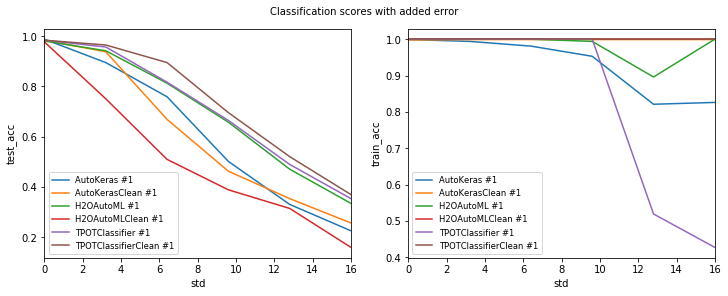

In [11]:
print_results_by_model(df,
    # ["train_labels", "test_labels"],
    ["mean", "min_val", "max_val", "train_labels", "test_labels"], 
    # err_param_name="max_angle",
    err_param_name="std",
    pipeline_name="best_pipeline"
)
visualize(df)